In [1]:
from dataset.dialogue_graph_datamodule import SubDialogueDataModule
import torch 
from tqdm import tqdm
from model import GiBERTino

# set relations to 19 in order to work
model = GiBERTino.load_from_checkpoint("alibaba-modernbert-molweni-epoch-epoch=08-val_loss=2.49.ckpt")

model.eval()
data_module = SubDialogueDataModule("data/MOLWENI/alibaba-graphs", "MOLWENI", num_workers=0)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Processing test data"):
        link_logits, rel_probs = model(batch)

        link_labels = batch[('edu', 'to', 'edu')].get('link_labels', None)
        rel_labels = batch[('edu', 'to', 'edu')].get('rel_labels', None)

        graphs = batch.to_data_list()
        for graph in graphs:
            graph_edge_index = batch.to_data_list()[0]["edu", "to", "edu"].edge_index.T

        print(link_labels.shape)
        break

2025-03-31 15:39:45,880 - INFO - Use pytorch device_name: cpu
2025-03-31 15:39:45,881 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-modernbert-base
Processing test data:   0%|          | 0/23 [00:14<?, ?it/s]

torch.Size([357])


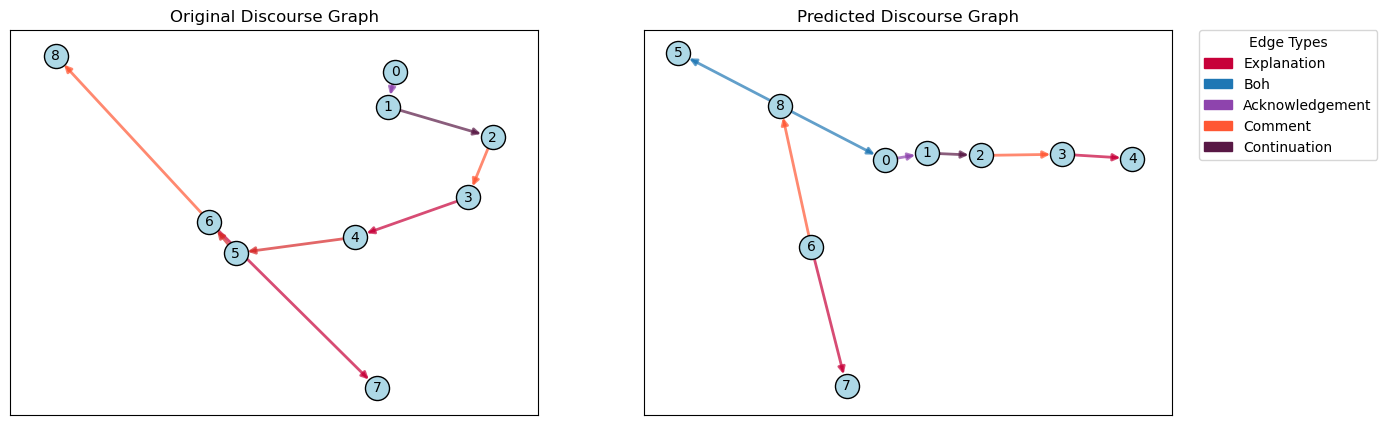

In [5]:
%reload_ext autoreload
%autoreload 2

from utils import create_graph_from_predictions

edge_index = batch.to_data_list()[0]["edu", "to", "edu"].edge_index.T
link_labels = batch.to_data_list()[0]["edu", "to", "edu"].link_labels
rel_labels = batch.to_data_list()[0]["edu", "to", "edu"].rel_labels

g = batch.to_data_list()[0]
preds = link_logits[:g["edu", "to", "edu"].link_labels.shape[0]]
relations = ["QAP",
                "Comment",
                "Clarification_question",
                "Continuation",
                "Acknowledgement",
                "Conditional",
                "Contrast",
                "Explanation",
                "Elaboration",
                "Result",
                "Correction",
                "Q-Elab",
                "Parallel",
                "Background",
                "Alternation",
                "Narration", 
                 "Test",
                    "Boh", 
                    "Test2",
            "Testina"]

create_graph_from_predictions(g, relations, preds)